In [171]:
import math
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

class Value:
     
     def __init__(self, data, _child=(), _op = "", label = ""):

          self.data = data
          self.grad = 0.0
          self._backward = lambda: None 
          self._prev = set(_child)
          self._op = _op
          self.label = label
         
      
     def __repr__(self):
            return f"Value(data = {self.data})" 
       
     def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)   
        out = Value(self.data  + other.data, (self, other), "+")
     
        def _backward():       
         self.grad += 1.0 * out.grad 
         other.grad += 1.0 * out.grad 
        out._backward = _backward
        return out
     
     def __radd__(self, other):
         return self.__add__(other)   
     
     def __mul__(self,other): 
         other = other if isinstance(other,Value) else Value(other)
         out = Value(self.data * other.data, (self, other), "*")
              
         def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad  
         out._backward = _backward
     
         return out
 
     def __pow__(self, other): 
         assert isinstance(other, (int, float))
         out = Value(self.data ** other, (self, ),f"**{other}")

         def _backward():
            self.grad += other  * (self.data** (other - 1)) * out.grad
         out._backward = _backward
         return out 
        
     def __rmul__(self, other): 
           return self * other 

     def __truediv__(self, other):  
        other = other if isinstance(other, Value) else Value(other)
        return self * (other ** -1)

     def __neg__(self):
          return self * -1

     def __sub__(self, other):
           return self + (-other)
          
     def tanh(self):
           x = self.data
           tanh = (math.exp(2 * x) - 1 ) / (math.exp(2 * x) +  1)
           out = Value(tanh, (self, ), "tanh")

           def _backward():
              self.grad +=  (1 - tanh**2) * out.grad
                  
           out._backward = _backward
           return out
         
     def relu(self):
        x = self.data 
        relu = x if x > 0 else 0
        out = Value(relu, (self, ), "relu")  

        def _backward():
            if x > 0:
             self.grad += out.grad * 1
            else: 
             self.grad += out.grad * 0
        out._backward  = _backward
        return out 

     def sigmoid(self):
         x = self.data
         sigmoid = 1 / (1 + math.exp(- x))
         out = Value(sigmoid, (self, ), "sigmoid") 

         def _backward():   
            local_grad = sigmoid * (1 - sigmoid)
            self.grad += out.grad * local_grad  

         out._backward = _backward
         return out 
              
         
     def exp(self): 
         x = self.data
         out = Value(math.exp(x), (self, ), "exp")

         def _backward():
            self.grad += out.data * out.grad
         out._backward  = _backward    
         return out 

     def log(self):  
        x = self.data
        assert x > 0 
        out = Value(math.log(x), (self,), "log")
        
        def _backward():
            self.grad += (1 / x) * out.grad
        out._backward = _backward
        return out
    
     def backward(self):
         
         topo = []
         visited = set()

         def build_topo(v):

            if v not in visited:
              visited.add(v)
              for child in v._prev:
                build_topo(child)
              topo.append(v)
         build_topo(self)  
         
         self.grad = 1
         for node in reversed(topo):
            node._backward()


In [35]:


def trace(root):
     nodes, edges = set(), set()
     def build(v):
          if v not in nodes:
               nodes.add(v)
               for child in v._prev:    
                    edges.add((child, v))
                    build(child)
     build(root)
     return nodes,edges
    
def draw_dot(root):   
    
     dot = Digraph(format = "svg", graph_attr = {"rankdir": "LR"})

     nodes, edges = trace(root)
     
     for n in nodes:
          uid = str(id(n))
          # Add node to graph
          dot.node(name=uid, label="{%s | data: %.4f | grad: %.4f}" % (n.label, n.data, n.grad) , shape="record")

          if n._op: 
               dot.node(name = uid + n._op, label = n._op)
               dot.edge(uid + n._op, uid)
              
     for n1, n2 in edges:
          # Add edge to graph
          dot.edge(str(id(n1)), str(id(n2)) + n2._op)
          
     return dot

 


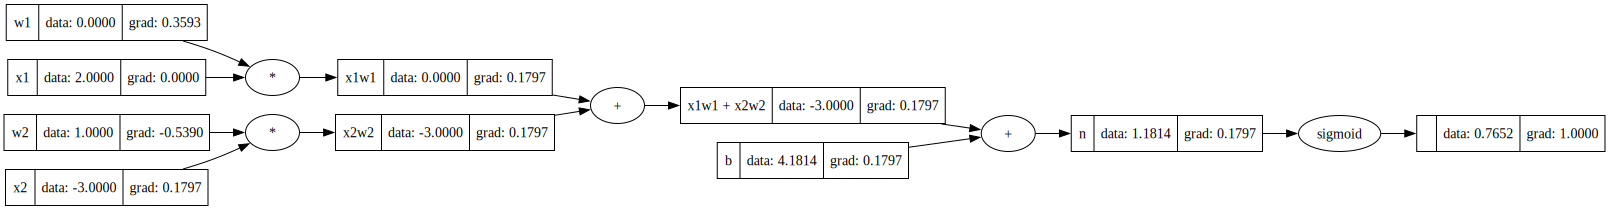

In [138]:
#inputs...
x1 = Value(2.0, label = "x1")
x2 = Value(-3.0, label = "x2")
#weights....
w1 = Value(0.0, label = "w1")
w2 = Value(1.0,label = "w2")
#bias....
b = Value(4.18137564527, label = "b")

# x1w1 + x2w2 + b 
x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
o  = n.sigmoid()
o.backward()
draw_dot(o)

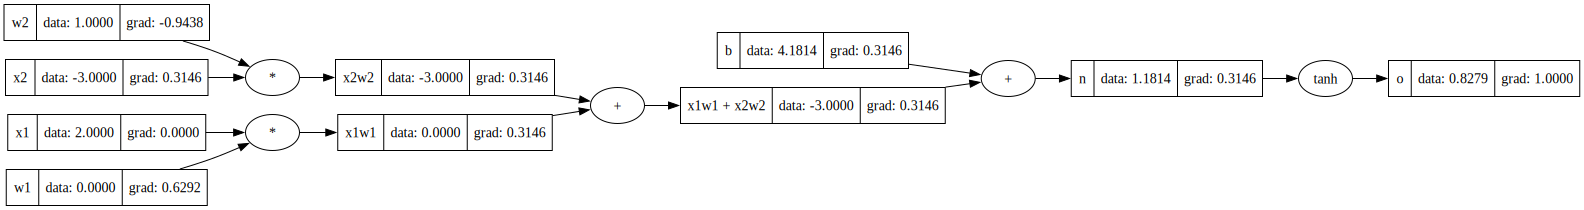

In [79]:
draw_dot(o)

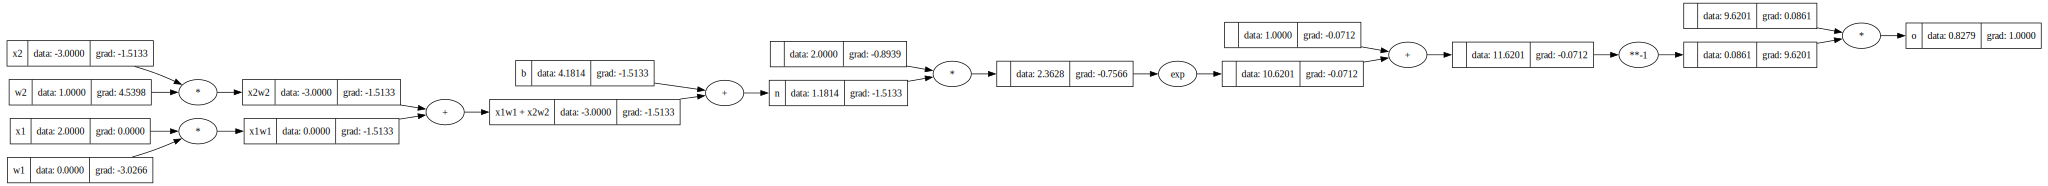

In [86]:
#inputs...
x1 = Value(2.0, label = "x1")
x2 = Value(-3.0, label = "x2")
#weights....
w1 = Value(0.0, label = "w1")
w2 = Value(1.0,label = "w2")
#bias....
b = Value(4.18137564527, label = "b")

# x1w1 + x2w2 + b 
x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"

#................
e = (2 * n).exp()  
o = (e - 1) / (e + 1)

#................
o.label = "o"
o.backward()
draw_dot(o)

In [101]:
o.item()

0.7064114945384358

In [217]:
import random 
class Neuron:

    def __init__(self,nin):

        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
         list = __builtins__.list
         act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
         out = act.tanh()
         return out

    def parameters(self):
        return self.w + [self.b]


class Layer: 

    def __init__(self, nin, nout): 
         self.neurons = [Neuron(nin) for _ in  range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs  
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
            sz = [nin] + nouts 
            self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
             for layer in self.layers:
                   x = layer(x)
             return x
    def parameters(self):
         return [p for layer in self.layers for p in layer.parameters()]

class MSE:

    def __init__(self, input, target):
         self.predictions = input
         self.targets = target
    
    def compute_loss(self):  
           squared_errors = [(pred - target)**2 for pred, target in zip(self.predictions, self.targets)]
           total_loss = sum(squared_errors)
           mean_loss = total_loss / len(self.predictions)
        
           return mean_loss 

class CrossEntropy: 

     def __init__(self, inputs, targets):
          self.predictions = inputs 
          self.targets = targets 
     
     def softmax(self):
         exp = [i.exp() for i in self.predictions]
         summed_exp = sum(exp)
         softmax = [e/ summed_exp for e in exp]
         return softmax 
     
     def compute_loss(self): 
           if isinstance(self.targets, int):
                one_hot = [0] * len(self.predictions)
                one_hot[self.targets] = 1
                targets = one_hot
           else:
            # Target is already one-hot encoded
                targets = self.targets

           probs = self.softmax()

           loss = Value(0.0)  
           for pred, target in zip(probs, self.targets):
             if target == 1:  
                # Add small epsilon to prevent log(0) which is undefined
                epsilon = 1e-15
                safe_pred = pred + epsilon  # Prevent log(0)
                loss = loss + (-1 * target * safe_pred.log())
        
           return loss

class RMSprop():

    def __init__(self, parameters, lr=0.001, decay_rate=0.9, eps=1e-8):
        self.parameters = parameters 
        self.lr = lr 
        self.decay_rate = decay_rate 
        self.eps = eps

        self.v = [0.0] * len(parameters)

    def step(self):
         for i, param in enumerate(self.parameters):
            if param.grad is not None:
                self.v[i] = self.decay_rate * self.v[i] + (1 - self.decay_rate) * (param.grad ** 2)
                adaptive_grad = param.grad / (self.v[i] ** 0.5 + self.eps)
                param.data -= self.lr * adaptive_grad
    
    def zero_grad(self): 
      for param in self.parameters:
          param.grad = 0.0

class Adam:

     def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.parameters = parameters
        self.lr = lr
        self.beta1 = beta1   
        self.beta2 = beta2   
        self.eps = eps

        self.m = [0.0] * len(parameters)
        self.v = [0.0] * len(parameters)
        self.t = 0

     def step(self):
            self.t += 1 
            for i, param in enumerate(self.parameters):
                g = param.grad 
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g * g)

                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)

                param.data -= self.lr * m_hat / ((v_hat ** 0.5) + self.eps)

     def zero_grad(self): 
         for param in self.parameters:
           param.grad = 0.0


In [148]:
x = [2.0, 3.0, 1.0]

n = MLP(3, [4,4,1])
n(x)

Value(data = 0.3976950127157259)

In [149]:
xs = [
      [2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, -1.0, 1.0]
]
ys = [1.0, -1.0, -1.0, 1] #desired target 

In [150]:
for k in range(40): 
 #forward pass
 ypred = [n(x) for x in xs] 
 loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
 
 #reseting gradient 
 for p in n.parameters():   
      p.grad = 0 
 
 #back pass
 loss.backward()
 
 #update
 for p in n.parameters():
    p.data += -0.05 * p.grad     
 print(k, loss.data)

0 4.7503862654069815
1 2.451123589187874
2 1.704690776583555
3 1.2711686517654364
4 0.9721933514146213
5 0.7616524570940122
6 0.6091364109332984
7 0.49659868541456864
8 0.41211028779126485
9 0.3475393176364694
10 0.29730805043558267
11 0.2575715017581353
12 0.2256531869988205
13 0.19965801907224845
14 0.17821986619999677
15 0.16033717659369623
16 0.145264356445916
17 0.13243857011506677
18 0.12142946884086327
19 0.11190407716881443
20 0.10360189576413557
21 0.0963170076210316
22 0.08988505695742173
23 0.08417366374236729
24 0.07907529030986726
25 0.07450187803893035
26 0.0703807754852765
27 0.06665161833989634
28 0.06326391768178823
29 0.06017518015303899
30 0.05734943110818114
31 0.0547560456045423
32 0.052368816436929005
33 0.05016520609204368
34 0.048125742440953224
35 0.04623352754546375
36 0.04447383606785704
37 0.04283378510833241
38 0.04130206132467653
39 0.03986869425460497


In [165]:
loss 

1.7790423478462927

In [229]:
model = MLP(3, [4, 4, 1])
model(x)
xs = [
      [2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, -1.0, 1.0]
]
ys = [1.0, -1.0, -1.0, 1] #desired target 
optimizer = Adam(model.parameters(), lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8)
"""optimizer = RMSprop(model.parameters(), lr=0.001, decay_rate=0.9, eps=1e-8 )"""

for epoch in range(100):

      optimizer.zero_grad()
      predictions = []
      for x in xs:
        pred = model(x)  
        predictions.append(pred)
      mse_loss = CrossEntropy(predictions, ys)
      loss = mse_loss.compute_loss()
      loss.backward()
      optimizer.step()
      print(epoch, loss)


0 Value(data = 3.3612751768842903)
1 Value(data = 2.9085977796987743)
2 Value(data = 2.7281843483743797)
3 Value(data = 2.6794456279619774)
4 Value(data = 2.6680821614727375)
5 Value(data = 2.664151938284207)
6 Value(data = 2.657273219542442)
7 Value(data = 2.6413211294604872)
8 Value(data = 2.61313430828409)
9 Value(data = 2.573552309114466)
10 Value(data = 2.5265893418481284)
11 Value(data = 2.47754304063058)
12 Value(data = 2.430860087738252)
13 Value(data = 2.388800001797046)
14 Value(data = 2.3514434464754825)
15 Value(data = 2.3169544067303924)
16 Value(data = 2.2810285282340517)
17 Value(data = 2.2358585662900268)
18 Value(data = 2.1716820824086223)
19 Value(data = 2.0874222716929203)
20 Value(data = 2.004040900799716)
21 Value(data = 1.939381504486555)
22 Value(data = 1.8877847296809724)
23 Value(data = 1.8462012754145376)
24 Value(data = 1.8153530792114845)
25 Value(data = 1.7917240920789248)
26 Value(data = 1.7712087096064617)
27 Value(data = 1.7527137650728775)
28 Value(data

In [230]:
predictions

[Value(data = 0.9993033135135351),
 Value(data = -0.9987263000609662),
 Value(data = -0.9998743581862367),
 Value(data = 0.9994524036933222)]

In [239]:
import math 
import random 

xs = [Value(x) for x in [i * 0.1 for i in range(-20, 21)]]   # x ∈ [-2, 2] in 0.1 steps
ys = [Value(math.sin(x.data)) for x in xs]                  # target y = sin(x)


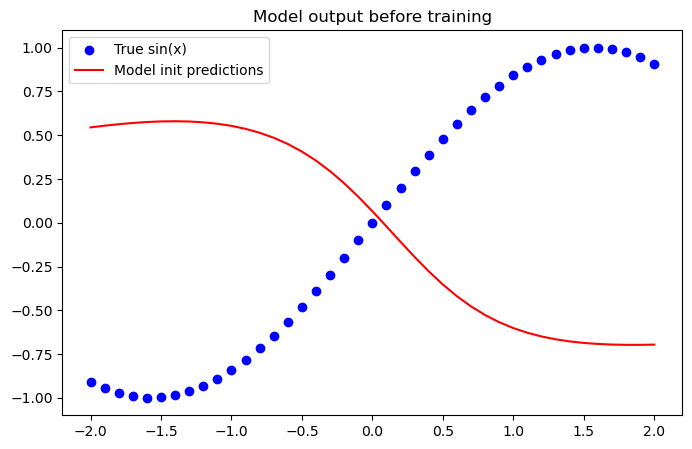

In [240]:
model = MLP(1, [10, 1])   # you already have this MLP from micrograd style

# 3. Loss and optimizer
optimizer = RMSprop(model.parameters(), lr=0.01, decay_rate=0.9, eps=1e-8)
loss_fn = MSE  # we’ll instantiate inside loop

with_preds = [model([x]).data for x in xs]   # forward pass once

plt.figure(figsize=(8, 5))
plt.scatter([x.data for x in xs], [y.data for y in ys], label="True sin(x)", color="blue")
plt.plot([x.data for x in xs], with_preds, label="Model init predictions", color="red")
plt.title("Model output before training")
plt.legend()
plt.show()


Epoch 0, Loss = 1.6782
Epoch 20, Loss = 0.0223
Epoch 40, Loss = 0.0044
Epoch 60, Loss = 0.0037
Epoch 80, Loss = 0.0034
Epoch 100, Loss = 0.0030
Epoch 120, Loss = 0.0025
Epoch 140, Loss = 0.0022
Epoch 160, Loss = 0.0020
Epoch 180, Loss = 0.0016


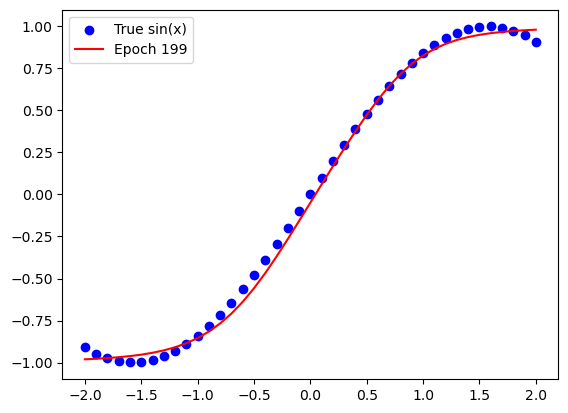

In [241]:
# 4. Training loop
for epoch in range(200):
    optimizer.zero_grad()

    # Forward pass
    preds = [model([x]) for x in xs]  
    loss = MSE(preds, ys).compute_loss()

    # Backprop
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss = {loss.data:.4f}")
 
preds = [model([x]).data for x in xs]
plt.scatter([x.data for x in xs], [y.data for y in ys], color="blue", label="True sin(x)")
plt.plot([x.data for x in xs], preds, color="red", label=f"Epoch {epoch}")
plt.legend()
plt.show()

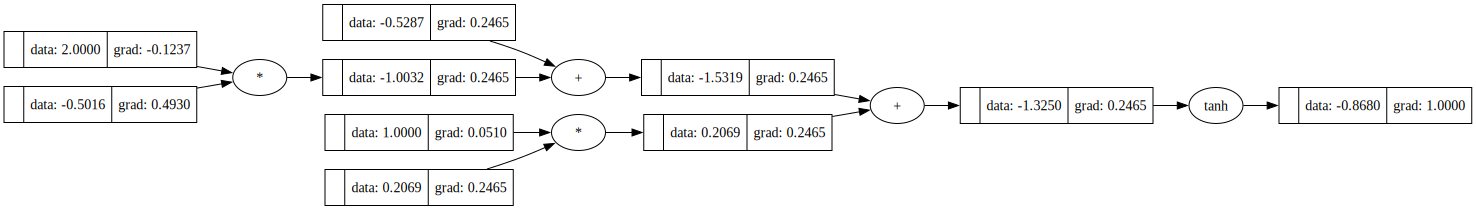

In [250]:
a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0

print(f'{g.data:.4f}')  
g.backward()
print(f'{a.grad:.4f}') 
print(f'{b.grad:.4f}') 

24.5000
140.0000
651.0000


In [261]:
import torch
import math

# NeuralGrad
x = Value(3.0)
y = Value(-2.0)
z = x + y + 5
z.backward()
grad_ng = (x.grad, y.grad, z.data)

    # PyTorch
xt = torch.tensor([3.0], dtype=torch.double, requires_grad=True)
yt = torch.tensor([-2.0], dtype=torch.double, requires_grad=True)
zt = xt + yt + 5
zt.backward()
grad_pt = (xt.grad.item(), yt.grad.item(), zt.item())
try: 
 assert math.isclose(grad_ng[2], grad_pt[2], rel_tol=1e-6)
 assert math.isclose(grad_ng[0], grad_pt[0], rel_tol=1e-6)
 assert math.isclose(grad_ng[1], grad_pt[1], rel_tol=1e-6)
 print("Test passed ✅")
except AssertionError:
    print("Test failed ❌")
    

Test passed ✅
